In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import CSVLogger
#from livelossplot import PlotLossesKeras
import os
import numpy as np
#from imgaug import augmenters as iaa
import cv2
import tensorflow as tf

Using TensorFlow backend.


In [2]:
def check_units(y_true, y_pred):
    if y_pred.shape[1] != 1:
        y_pred = y_pred[:,1:2]
        y_true = y_true[:,1:2]
    return y_true, y_pred

def precision(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    y_true, y_pred = check_units(y_true, y_pred)
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def matthews_correlation(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6487624621059714067
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4950209331
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14655543199640424894
physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [4]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [5]:
x_train = np.load("datasets/norm/x_train_norm_200.npy")
y_train = np.load("datasets/norm/y_train_norm_200.npy")
x_train.shape, y_train.shape

((22046, 200, 200, 3), (22046, 2))

In [6]:
x_val = np.load("datasets/norm/x_val_norm_200.npy")
y_val = np.load("datasets/norm/y_val_norm_200.npy")
x_val.shape, y_val.shape

((2756, 200, 200, 3), (2756, 2))

In [7]:
x_test = np.load("datasets/norm/x_test_norm_200.npy")
y_test = np.load("datasets/norm/y_test_norm_200.npy")
x_test.shape, y_test.shape

((2756, 200, 200, 3), (2756, 2))

In [8]:
print(x_train.shape, y_train.shape)
print(x_val.shape, x_test.shape, y_val.shape, y_test.shape)

(22046, 200, 200, 3) (22046, 2)
(2756, 200, 200, 3) (2756, 200, 200, 3) (2756, 2) (2756, 2)


In [9]:
IMAGE_SIZE = 200
IMAGE_WIDTH, IMAGE_HEIGHT = IMAGE_SIZE, IMAGE_SIZE
EPOCHS = 30
BATCH_SIZE = 64
TEST_SIZE = 30

In [10]:
TRAINING_LOGS_FILE = "training_logs.csv"
TEST_LOGS_FILE = "test_logs.csv"
MODEL_SUMMARY_FILE = "model_summary.txt"
TEST_FILE = "test_file.txt"
MODEL_FILE = "very-normal-200-exp1.h5"

In [11]:
input_shape = (200, 200, 3)

In [12]:
input_shape

(200, 200, 3)

In [13]:
model = None
model = Sequential()

In [14]:
model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape, activation='relu'))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2))
model.add(Activation('softmax'))
    
model.compile(loss='binary_crossentropy',
            optimizer="adadelta",
            metrics=['accuracy', precision, recall, f1, matthews_correlation, auc])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 200, 200, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 200, 200, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 100, 100, 64)      18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 100, 100, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 50, 50, 128)       73856     
__________

In [15]:
model.fit(x=x_train, y=y_train, validation_data = (x_val,y_val), epochs=EPOCHS, verbose=1)

Train on 22046 samples, validate on 2756 samples
Epoch 1/30
22046/22046 [==============================] - 130s 6ms/step - loss: 0.6939 - acc: 0.5055 - precision: 0.4518 - recall: 0.5397 - f1: 0.4355 - matthews_correlation: 0.0110 - auc: 0.5040 - val_loss: 0.6929 - val_acc: 0.4971 - val_precision: 0.4971 - val_recall: 1.0000 - val_f1: 0.6580 - val_matthews_correlation: 0.0000e+00 - val_auc: 0.5064
Epoch 2/30
22046/22046 [==============================] - 126s 6ms/step - loss: 0.4359 - acc: 0.7693 - precision: 0.7870 - recall: 0.7748 - f1: 0.7487 - matthews_correlation: 0.5464 - auc: 0.5834 - val_loss: 0.1517 - val_acc: 0.9481 - val_precision: 0.9378 - val_recall: 0.9575 - val_f1: 0.9462 - val_matthews_correlation: 0.8945 - val_auc: 0.73100.6597 - acc: 0.6047 - precision: 0.6224 - recall: 0.6304 - f1: 0.5665 - matthews - ETA: 53s - loss: 0.6283 - acc: 0.6300 - precision: 0.6508 - recall: 0.6486 - f1: 0.5941 - matthews_correl - ETA: 48s - loss: 0.6003 - acc: 0.6510 - precision: 0.6703 - 

22046/22046 [==============================] - 126s 6ms/step - loss: 0.0352 - acc: 0.9892 - precision: 0.9931 - recall: 0.9857 - f1: 0.9890 - matthews_correlation: 0.9785 - auc: 0.9858 - val_loss: 0.2303 - val_acc: 0.9565 - val_precision: 0.9725 - val_recall: 0.9395 - val_f1: 0.9542 - val_matthews_correlation: 0.9126 - val_auc: 0.9862
Epoch 21/30
22046/22046 [==============================] - 127s 6ms/step - loss: 0.0305 - acc: 0.9912 - precision: 0.9950 - recall: 0.9873 - f1: 0.9908 - matthews_correlation: 0.9823 - auc: 0.9866 - val_loss: 0.2426 - val_acc: 0.9554 - val_precision: 0.9573 - val_recall: 0.9503 - val_f1: 0.9524 - val_matthews_correlation: 0.9090 - val_auc: 0.9870
Epoch 22/30
22046/22046 [==============================] - 127s 6ms/step - loss: 0.0326 - acc: 0.9906 - precision: 0.9939 - recall: 0.9873 - f1: 0.9903 - matthews_correlation: 0.9812 - auc: 0.9874 - val_loss: 0.2697 - val_acc: 0.9481 - val_precision: 0.9815 - val_recall: 0.9122 - val_f1: 0.9440 - val_matthews_cor

In [16]:
model.save("very-normal-exp2.h5")

In [17]:
 def plot_loss_accu(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'g')
    plt.plot(epochs, val_loss, 'y')
    plt.title('Loss')
    plt.legend(['train', 'val'], loc='upper right')
    plt.grid(True)
    plt.savefig('exp2_loss_normal.jpg', dpi=300)
    plt.show()
    
def plot_loss(history):
    loss = history.history['acc']
    val_loss = history.history['val_acc']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'r')
    plt.plot(epochs, val_loss, 'b')
    plt.title('Accuracy')
    plt.legend(['train', 'val'], loc='lower right')
    plt.grid(True)
    plt.savefig('exp2_acc_normal.jpg', dpi=300)
    plt.show()

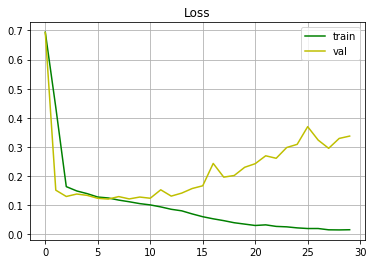

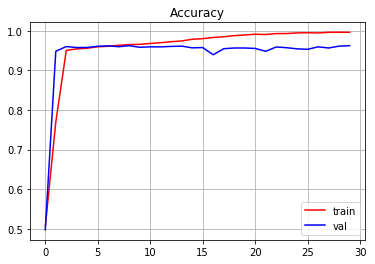

Done!


In [18]:
plot_loss_accu(model.history)
plot_loss(model.history)
print("Done!")

In [19]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2756/2756 [==============================] - 6s 2ms/step
Test loss: 0.3873219742311083
Test accuracy: 0.9560957910014514


In [20]:
y_pred = model.predict(x_test)
# get labels from predictions
pred_labels = np.array([np.argmax(pred) for pred in y_pred])

#convert ground truths to column values
y_test = np.argmax(y_test, axis=1)
accuracy = np.mean((y_test==pred_labels))


In [21]:
y_pred.shape

(2756, 2)

In [22]:
accuracy

0.9560957910014514

In [23]:
np.save("y_pred_verynormal_exp2.npy", y_pred)